In [1]:
''' Import packages. '''
# Time packages
import calendar, cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy, numba
# Local data storage packages
import functools, importlib, os, pickle, collections, sys

import pandas as pd, xarray as xr, nc_time_axis
xr.set_options(keep_attrs=True)
# Visualization tools
import cartopy, cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as plt

# Local imports
sys.path.insert(1, '/projects/GEOCLIM/gr7610/scripts')
import derived, utilities, visualization
importlib.reload(utilities);
importlib.reload(visualization);
importlib.reload(derived);

In [2]:
def get_field_name_alias(field_name: str) -> str:

    ''' Get symbolic name for field. '''

    aliases = {'precip': 'P',
               'evap': 'E',
               'netrad_toa': 'R$_\mathrm{TOA}$',
               'trans_atm': '$\Delta$F$_\mathrm{atm}$',
               'trans_ocn': '$\Delta$F$_\mathrm{ocn}$',
               'trans_lq': '$Lq$',
               'trans_cpT': '$c_pT$'}

    return aliases[field_name] if field_name in aliases.keys() else field_name

In [3]:
def inferred_heat_transport(dataset: xr.DataArray,
                            field_name: str='netrad_toa',
                            flux_adjustment: int|float=0,
                            normalize_units: str='PW'):
    '''
    Credit: Brian Rose, UAlbany; https://github.com/brian-rose/ClimateLaboratoryBook/blob/main/courseware/advanced-heat-transport.ipynb.
    Modifications made by G. Rios.
    
    Compute heat transport as integral of local energy imbalance.
    As either numpy array or xarray.DataArray, returns the heat transport in PW.
    Will attempt to return data in xarray.DataArray if possible.
    '''

    latitude_dimension_name = 'grid_yt'
    # Get averaging dimensions
    averaging_dimensions = [d for d in dataset.dims if d != latitude_dimension_name]
    # Get degrees latitude in units of radians
    lat_radians = dataset[latitude_dimension_name] * np.pi/180
    # Weigh the dataset by latitude
    
    dataset_weighted = (dataset[field_name] - flux_adjustment).mean(averaging_dimensions) * np.cos(lat_radians)
    # Get global integral
    integral = scipy.integrate.cumulative_trapezoid(dataset_weighted, 
                                                    x=lat_radians, 
                                                    initial=0., 
                                                    axis=dataset_weighted.get_axis_num(latitude_dimension_name))

    unit_prefix = {'PW': 1e-15, 'MW': 1e-6, 'GW': 1e-9, 'KW': 1e-3}
    
    result = (unit_prefix[normalize_units] * 2 * np.pi * utilities.get_constants('a')**2 * integral)
    
    if isinstance(dataset_weighted, xr.DataArray):
        result_xarray = dataset_weighted.copy()
        result_xarray.values = result
        return result_xarray, normalize_units
    else:
        return result, normalize_units

In [40]:
def check_moisture_units(dataset: xr.Dataset) -> xr.Dataset:

    assert 'precip' in dataset.data_vars or 'evap' in dataset.data_vars

    # If precipitation or evaporation maxima are very low, it is assumed they are in units of kg/m^2/s instead of mm/d
    for field_name in ['precip', 'evap']:
        if dataset[field_name].max() < 0.01:
            dataset[field_name] = dataset[field_name] * 86400

    return dataset

In [42]:
def get_derived_fields(dataset: xr.Dataset,
                       diagnostic: bool=False) -> xr.Dataset:

    diagnostic_tag = '[get_derived_fields()]'

    assert isinstance(dataset, xr.Dataset), f'Input data must be an xarray Dataset. It is currently of type {type(dataset)}.'

    # Define each derived field by its constituent fields and the derivation function.
    derived_fields = {'p-e': {'field_names': ['precip', 'evap'],
                              'func': lambda x: x['precip'] - x['evap'],
                              'long_name': 'surface moisture flux',
                              'units': 'mm d$^{-1}$'},
                      'swabs_toa': {'field_names': ['swdn_toa', 'swup_toa'],
                                    'func': lambda x: x['swdn_toa'] - x['swup_toa'],
                                    'long_name': 'absorbed shortwave radiation',
                                    'units': 'W m$^{-2}$'},
                      'netrad_surf': {'field_names': ['swup_sfc', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc'],
                                      'func': lambda x: -x['swup_sfc'] + x['swdn_sfc'] - x['lwup_sfc'] + x['lwdn_sfc'],
                                      'long_name': 'net downward surface radiative flux',
                                      'units': 'W m$^{-2}$'},
                      'le': {'field_names': ['evap'],
                             'func': lambda x: (x['evap'] / 86400) * utilities.get_constants('L_v'),
                             'long_name': 'latent heat flux',
                             'units': 'W m$^{-2}$'},
                      'trans_atm': {'field_names': ['netrad_toa', 'netrad_surf', 'le', 'shflx'],
                                  'func': lambda x: x['netrad_toa'] - x['netrad_surf'] +  x['le'] + x['shflx'],
                                  'long_name': 'northward atmospheric energy transport',
                                  'units': 'W m$^{-2}$'},
                      'trans_ocn': {'field_names': ['netrad_toa', 'netrad_surf', 'evap', 'shflx'],
                                  'func': lambda x: x['netrad_toa'] - x['trans_atm'],
                                  'long_name': 'northward oceanic energy transport',
                                  'units': 'W m$^{-2}$'},
                      'trans_lq': {'field_names': ['p-e'],
                             'func': lambda x: -(x['p-e'] / 86400) * utilities.get_constants('L_v'),
                             'long_name': 'net moisture transport',
                             'units': 'W m$^{-2}$'},
                      'trans_cpT': {'field_names': ['p-e', 'trans_atm'],
                              'func': lambda x: x['trans_atm'] - x['trans_lq'],
                              'long_name': 'net dry transport',
                              'units': 'W m$^{-2}$'}}

    # Iterate over all fields and derived if the constituent fields are in the dataset.
    for derived_field, derived_dict in derived_fields.items():
        if diagnostic:
            print(f'{diagnostic_tag} Inspecting data to derive field {derived_field} using {derived_dict['field_names']}...')
            
        # Check that all fields for derived quantity are in dataset
        check_fields = [field in dataset.data_vars for field in derived_dict['field_names']]
        if not (sum(check_fields) == len(derived_dict['field_names'])):
            if diagnostic:
                print(f'{diagnostic_tag} not all fields found for data when deriving {derived_field}; only fields ...')
            continue
        # Derive the quantity
        dataset[derived_field] = derived_dict['func'](dataset)
        
    return dataset

In [5]:
def center_twin_axes(ax: matplotlib.axes.Axes,
                     ax_diff: matplotlib.axes.Axes):

    ''' Adjusts axes such that their zero points coincide. '''

    # Conditional to determine if axis crosses zero
    crosses_zero = lambda ax: np.sign(min(ax.get_ylim())) != np.sign(max(ax.get_ylim()))

    if crosses_zero(ax) and crosses_zero(ax_diff):

        ax_min_y, ax_max_y = min(ax.get_ylim()), max(ax.get_ylim())
        ax_ratio = ax_max_y / ax_min_y
        
        ax_diff_min_y, ax_diff_max_y = min(ax_diff.get_ylim()), max(ax_diff.get_ylim())
        ax_diff_ratio = ax_diff_max_y / ax_diff_min_y
        print(f'Primary axis ratio of maximum to minimum y-axis limits: {ax_ratio:.2f};\nSecondary axis ratio of maximum to minimum y-axis limits: {ax_diff_ratio:.2f}')
        
        ax_diff_min_y_adj, ax_diff_max_y_adj = [ax_diff_min_y, ax_diff_max_y * (ax_ratio) / ax_diff_ratio]
        mag_ratio_min, mag_ratio_max = 1, 1
        if ax_diff_min_y_adj > ax_diff_min_y:
            mag_ratio_min = ax_diff_min_y/ax_diff_min_y_adj
        if ax_diff_max_y_adj < ax_diff_max_y:
            mag_ratio_max = ax_diff_max_y/ax_diff_max_y_adj
        
        mag_ratio = max([mag_ratio_min, mag_ratio_max])
        ax_diff.set_ylim(mag_ratio * np.array([ax_diff_min_y_adj, ax_diff_max_y_adj]))

In [34]:
def plot_zonal_mean(datasets: dict[str: xr.Dataset],
                    configurations: list[str],
                    field_name: str,
                    rolling_degrees: int=10):

    ''' Plots zonal-time means of a given field in the specified configurations of a Dataset dictionary. '''

    # Boolean to see if a difference configuration exists
    difference_configuration_exists = True if 'DIFF' in ''.join(configurations) else False

    ''' Initialize visualization. '''
    # Define plot parameters
    linestyles = [':', (0, (5, 5)), (0, (3, 1))]
    long_name, units = visualization.field_properties(field_name)
    field_name_alias = get_field_name_alias(field_name)
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(6, 3), dpi=144)
    
    ax.axhline(0, c='k', lw=0.5)
    ax.axvline(0, c='k', lw=0.5)
    
    ax_diff = ax.twinx()
    
    # Iterate over each configuration
    for config_index, config_name in enumerate(configurations):
        # Define configuration-specific parameters
        iter_ax = ax_diff if 'diff' in config_name.lower() else ax
        linecolor = (0, 0, 0, 1) if 'diff' in config_name.lower() else (0, 0, 0, 0.5)
        linewidth = 2 if 'diff' in config_name.lower() else 1
        linestyle = '-' if 'diff' in config_name.lower() else linestyles[config_index]
        
        # Get averaging dimensions
        averaging_dimensions = [d for d in datasets[config_name][field_name].dims if d != 'grid_yt']
        # Perform averaging
        TMP = datasets[config_name][field_name].mean(averaging_dimensions).rolling(grid_yt=(rolling_degrees * 2), center=True).mean('grid_yt')
        # Plot the zonal-time mean data
        im = iter_ax.plot(TMP.grid_yt, TMP, label=config_name,
                          c=linecolor, lw=linewidth, ls=linestyle)
    
    # Set axis limits and scale axes such that horizontal zero lines are matches
    ax.set_xlim([-90 + rolling_degrees, 90 - rolling_degrees])
    center_twin_axes(ax, ax_diff)
    ax_diff.axhline(0, c='k', lw=0.5)
    
    ax.set_xlabel('Latitude')
    ax.set_ylabel(f'{long_name}\n[{units}]', wrap=True)
    ax_diff.set_ylabel(f'$\delta$ {units}', rotation=270, labelpad=15)
    
    fig.tight_layout()
    fig.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize=9, frameon=False, bbox_transform=ax.transAxes)

In [113]:
importlib.reload(utilities)
model_name = 'AM2.5'
experiment_type = '0N'
experiment_names = [f'CTL1990.{experiment_type}', f'CTL1990_SWISHE.{experiment_type}']
year_range = (2, 17)
fields = ['netrad_toa', 'evap', 'precip', 'shflx', 'swdn_sfc', 'swup_sfc', 'lwdn_sfc', 'lwup_sfc']
data_type = 'atmos_month'
npes = 540

dataset = {model_name: {}}
for experiment_name in experiment_names:

    dirname = f'/scratch/gpfs/GEOCLIM/gr7610/tiger3/{model_name}/work/{experiment_name}_tiger3_intelmpi_24_{npes}PE/POSTP'
    
    pathnames = [f'{dirname}/{year:04d}0101.{data_type}.nc' for year in range(2, 30)]
    pathnames = [pathname for pathname in pathnames if pathname.split('/')[-1] in os.listdir(dirname)]
        
    dataset[model_name][experiment_name] = xr.open_mfdataset(pathnames)[fields].load()
    dataset[model_name][experiment_name] = check_moisture_units(dataset[model_name][experiment_name])

In [114]:
configuration_aliases = {f'CTL1990.{experiment_type}': 'CTL',
                         f'CTL1990_SWISHE.{experiment_type}': 'EXP'}

data = {}
for k in dataset.keys():
    for sk in dataset[k].keys():
        TMP = get_derived_fields(dataset=dataset[k][sk], diagnostic=False)
        config_alias = configuration_aliases[sk]
        data[f'{k}-{config_alias}'] = dataset[k][sk]
        del TMP

data[f'{model_name}-DIFF.CTL-EXP'] = data[f'{model_name}-CTL'] - data[f'{model_name}-EXP']

### Zonal means

Primary axis ratio of maximum to minimum y-axis limits: -0.47;
Secondary axis ratio of maximum to minimum y-axis limits: -1.66
Primary axis ratio of maximum to minimum y-axis limits: -0.70;
Secondary axis ratio of maximum to minimum y-axis limits: -1.44


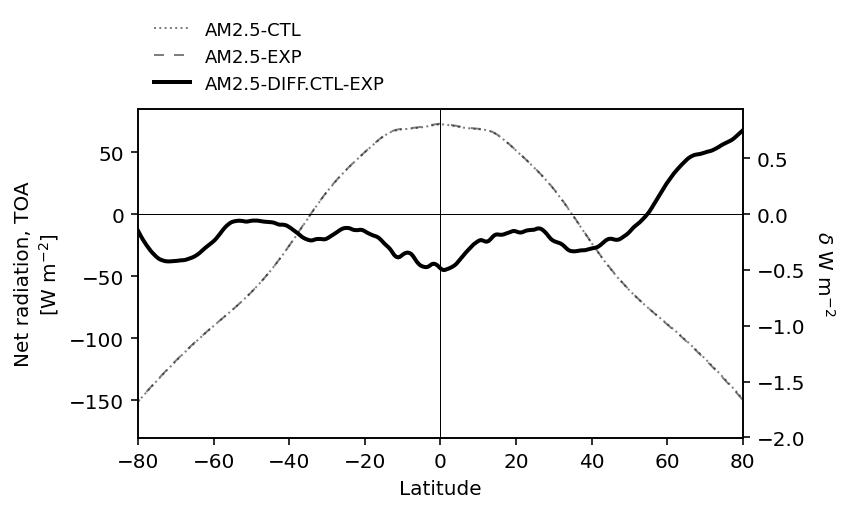

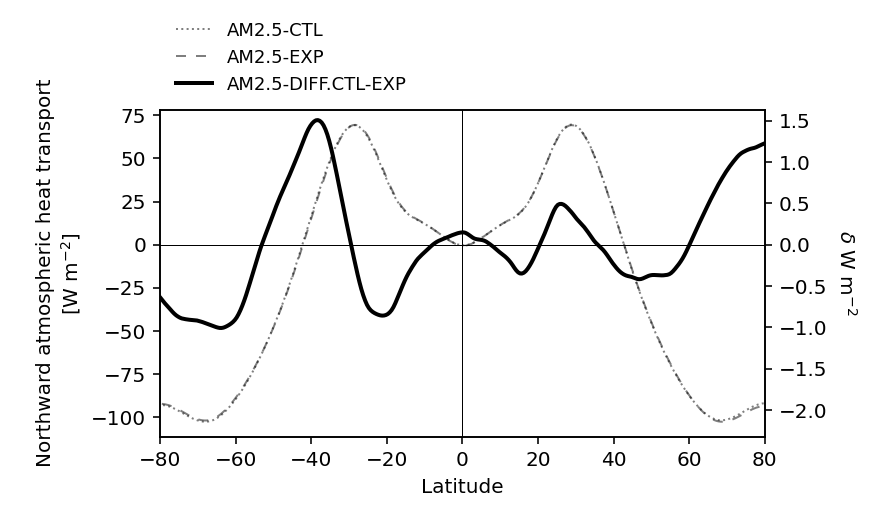

In [115]:
configurations = ['AM2.5-CTL', 'AM2.5-EXP', 'AM2.5-DIFF.CTL-EXP']

for field_name in ['netrad_toa', 'trans_atm']:
    plot_zonal_mean(datasets=data,
                    configurations=configurations,
                    field_name=field_name)

### Transport

Energy flux equator at: -19.25 N


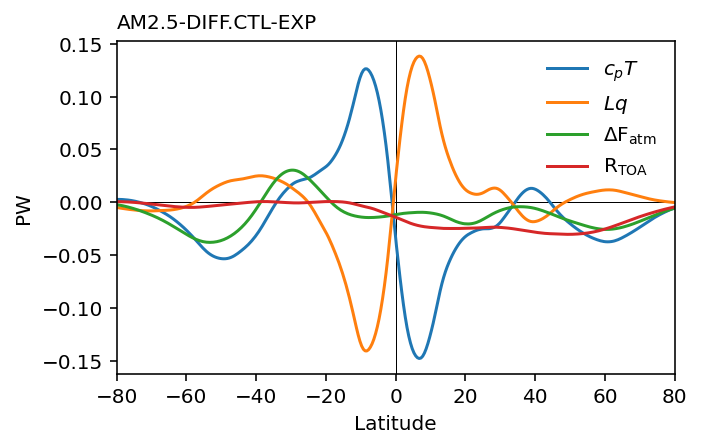

In [118]:
field_names = ['trans_cpT', 'trans_lq', 'trans_atm', 'netrad_toa']
rolling_degrees = 10

fig, ax = plt.subplots(figsize=(5, 3), dpi=144)

ax.axhline(0, c='k', lw=0.5)
ax.axvline(0, c='k', lw=0.5)

config = 'AM2.5-DIFF.CTL-EXP'
# config = 'AM2.5-CTL' 

transports = {}
for field_name in field_names:
    adjustment = data[config][field_name].mean(['grid_xt', 'time']).weighted(np.cos(np.deg2rad(data[config].grid_yt))).mean()
    
    transports[field_name], units = inferred_heat_transport(dataset=data[config],
                                                            field_name=field_name,
                                                            flux_adjustment=adjustment,
                                                            normalize_units='PW')
    
    TMP = transports[field_name].rolling(grid_yt=(rolling_degrees * 2), center=True).mean('grid_yt')
    im = ax.plot(TMP.grid_yt, TMP, label=get_field_name_alias(field_name))


ax.legend(frameon=False)

ax.set_xlim([-90 + rolling_degrees, 90 - rolling_degrees])

ax.set_xlabel('Latitude')
ax.set_ylabel(f'{units}')

ax.set_title(config.upper(), fontsize=10, ha='left', loc='left')

# Claculate the energy flux equator (where atmospheric transport = 0)
lat_range = slice(-60, 60)
index_min_atm = abs(transports['trans_atm'].sel(grid_yt=lat_range)).argmin()
print(f'Energy flux equator at: {transports['trans_atm'].sel(grid_yt=lat_range).isel(grid_yt=index_min_atm).grid_yt.item():.2f} N')